In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from environment.env import SpatialKuramoto
from environment.utils import (
    band_pass_envelope,
    generate_w0_with_locus,
    create_distance_matrix,
    units2sec, sec2units,
)
from environment.env_configs.env1 import params_dict_train

np.random.seed(10)
n_neurons = 512
grid_size = [8, 8, 8]
coord_modif = 0.1

You can also explore: 
- Various features of the model: Plasticity, Electrode drift
- Responce to different aDBS algorithms

## LFP and Power spectral density of the environment

In [4]:
# Define natural freqs. of neurons 
(w0, ncoords, ngrid,
    w0_temp_, w_locus, lmask) = generate_w0_with_locus(
            n_neurons, grid_size, coord_modif,
            locus_center=params_dict_train['locus_center'],
            locus_size=params_dict_train['locus_size'],
            wmuL=params_dict_train['wmuL'],
            wsdL=params_dict_train['wsdL'],
            show=False, vertical_layer=4)

# 1. Instantiate the env and check
params_dict_train['w0'] = w0
params_dict_train['w0_without_locus'] = w0_temp_
params_dict_train['locus_without_w0'] = w_locus
params_dict_train['locus_mask'] = lmask

params_dict_train['neur_coords'] = ncoords
params_dict_train['neur_grid'] = ngrid
params_dict_train['reward_func'] = 'bbpow_action'
params_dict_train['dbs_action_bounds'] = [-5, 5]

env = SpatialKuramoto(params_dict=params_dict_train)

No temporal drift events!


DBS affects 512 neurons, min=0.307 & max=1.0


### Run environment for 800 steps without stimulation

In [5]:
init = env.reset()

solutions = []
recordings = []
for i in tqdm(range(800)):   # 300
     l = env.step([0.])
     m = env.theta_mean
     r = env.theta_records
     theta_state, rew, is_done, _, _ = l
     solutions.append(m)
     recordings.append(r)

DBS affects 512 neurons, min=0.307 & max=1.0


100%|██████████| 800/800 [00:47<00:00, 16.96it/s]


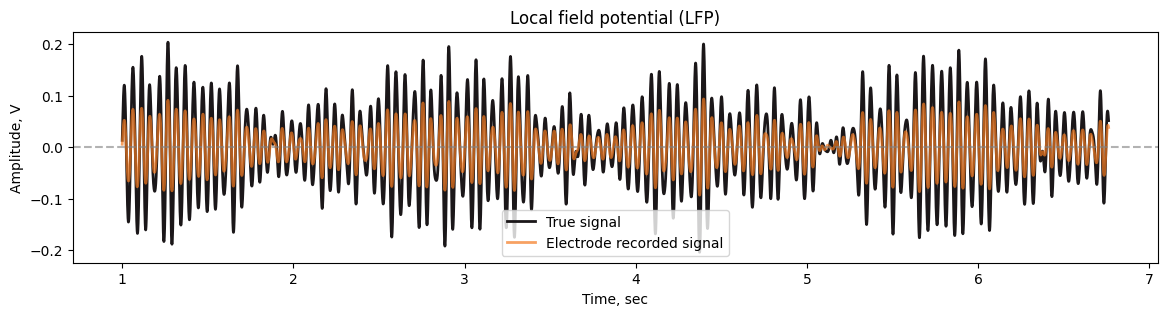

In [6]:
true_lfp_sig = np.concatenate(solutions)
recorded_sig = np.concatenate(recordings)

psd_dt = units2sec(env.params_dict['verbose_dt'])
trans_time = units2sec(100)
end_time = true_lfp_sig.shape[0] * psd_dt
times = np.linspace(trans_time, end_time, true_lfp_sig.shape[0])

fig, ax = plt.subplots(1,1, figsize=(14, 3))
nn = 13_500
true_lfp_sig_filt, _ = band_pass_envelope(true_lfp_sig, 1/psd_dt, order=2)
recorded_sig_filt, _ = band_pass_envelope(recorded_sig, 1/psd_dt, order=2)
plt.plot(times[:nn], true_lfp_sig_filt[:nn],
         lw=2, label='True signal', c='#1B1719')
plt.plot(times[:nn], recorded_sig_filt[:nn],
         lw=2, label='Electrode recorded signal', alpha=0.7, c='#F47A20')
plt.axhline(0, c='gray', alpha=0.6, linestyle='dashed')
plt.title('Local field potential (LFP)')
plt.xlabel('Time, sec')
plt.ylabel('Amplitude, V')
plt.legend()
plt.show()

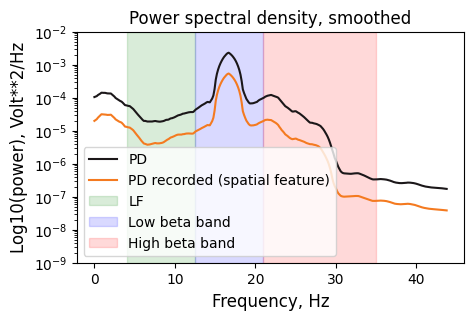

In [7]:
# PSD plotting 
start_idx, cut_idx = 0, 300
dt = units2sec(env.params_dict['verbose_dt'])
n = true_lfp_sig.shape[0]
ft = np.abs(np.fft.rfft(true_lfp_sig)/n)**2 * 2
freq = np.fft.rfftfreq(n, dt)
n0 = recorded_sig.shape[0]
ft0 = np.abs(np.fft.rfft(recorded_sig)/n0)**2 * 2
freq0 = np.fft.rfftfreq(n0, dt)

# Filter psd
from scipy.signal import filtfilt
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
ft = filtfilt([1,1,1,1,1,1,1,1,1,1,1,1,], 5, ft)
ft0 = filtfilt([1,1,1,1,1,1,1,1,1,1,1,1,], 5, ft0)

fig, ax = plt.subplots(1,1, figsize=(5, 3))
plt.semilogy(freq[start_idx:cut_idx], ft[start_idx:cut_idx],
                c='#1B1719', lw=1.5, label='PD')
plt.semilogy(freq0[start_idx:cut_idx], ft0[start_idx:cut_idx],
                c='#F47A20', lw=1.5, label='PD recorded (spatial feature)')
plt.xlabel('Frequency, Hz', fontsize=12)
plt.ylabel('Log10(power), Volt**2/Hz', fontsize=12)

# beta ranges: low (13–20 Hz) and high (21–35 Hz)
ax.axvspan(4, 12.5, alpha=0.15, color='green', label='LF')
ax.axvspan(12.5, 21, alpha=0.15, color='blue', label='Low beta band')
ax.axvspan(21, 35, alpha=0.15, color='red', label='High beta band')
plt.title(f'Power spectral density, smoothed')
plt.legend()
plt.ylim([1e-9, 1e-2])
plt.show()

### Now let's run the same model with HF-DBS stimulation and compare true LFP of non-stimulated model and true LFP of the model with stimulation

In [8]:
### Run environment for 800 steps with stimulation

init = env.reset()

solutions_with_stim = []
recordings_with_stim = []
for i in tqdm(range(800)):   # 300
     l = env.step([1.])
     m = env.theta_mean
     r = env.theta_records
     theta_state, rew, is_done, _, _ = l
     solutions_with_stim.append(m)
     recordings_with_stim.append(r)

DBS affects 512 neurons, min=0.307 & max=1.0


100%|██████████| 800/800 [00:44<00:00, 17.88it/s]


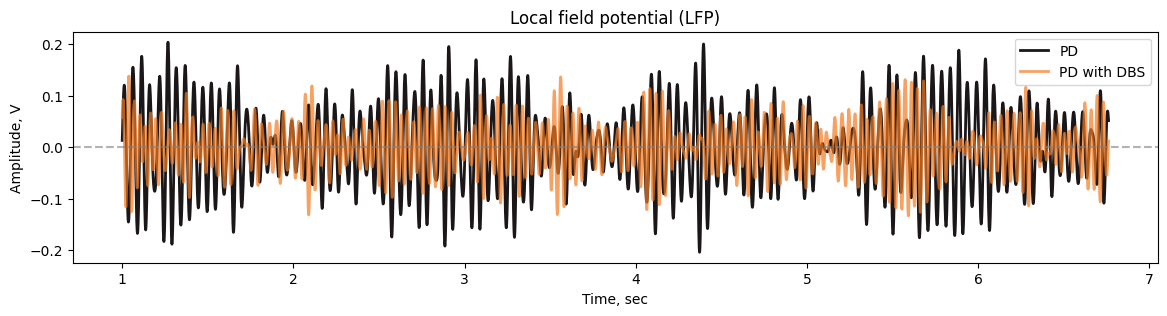

In [9]:
true_lfp_sig = np.concatenate(solutions)
true_lfp_sig_with_stim = np.concatenate(solutions_with_stim)

psd_dt = units2sec(env.params_dict['verbose_dt'])
trans_time = units2sec(100)
end_time = true_lfp_sig_with_stim.shape[0] * psd_dt
times = np.linspace(trans_time, end_time, true_lfp_sig.shape[0])

fig, ax = plt.subplots(1,1, figsize=(14, 3))
nn = 13_500
true_lfp_sig_filt, _ = band_pass_envelope(true_lfp_sig, 1/psd_dt, order=2)
recorded_sig_filt, _ = band_pass_envelope(true_lfp_sig_with_stim, 1/psd_dt, order=2)
plt.plot(times[:nn], true_lfp_sig_filt[:nn],
         lw=2, label='PD', c='#1B1719')
plt.plot(times[:nn], recorded_sig_filt[:nn],
         lw=2, label='PD with DBS', alpha=0.7, c='#F47A20')
plt.axhline(0, c='gray', alpha=0.6, linestyle='dashed')
plt.title('Local field potential (LFP)')
plt.xlabel('Time, sec')
plt.ylabel('Amplitude, V')
plt.legend()
plt.show()

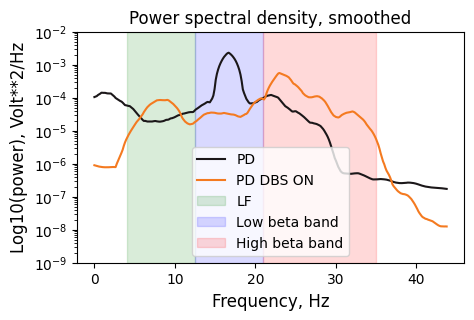

In [10]:
# PSD plotting 
start_idx, cut_idx = 0, 300
dt = units2sec(env.params_dict['verbose_dt'])
n = true_lfp_sig.shape[0]
ft = np.abs(np.fft.rfft(true_lfp_sig)/n)**2 * 2
freq = np.fft.rfftfreq(n, dt)
n0 = true_lfp_sig_with_stim.shape[0]
ft0 = np.abs(np.fft.rfft(true_lfp_sig_with_stim)/n0)**2 * 2
freq0 = np.fft.rfftfreq(n0, dt)

# Filter psd
from scipy.signal import filtfilt
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
ft = filtfilt([1,1,1,1,1,1,1,1,1,1,1,1,], 5, ft)
ft0 = filtfilt([1,1,1,1,1,1,1,1,1,1,1,1,], 5, ft0)

fig, ax = plt.subplots(1,1, figsize=(5, 3))
plt.semilogy(freq[start_idx:cut_idx], ft[start_idx:cut_idx],
                c='#1B1719', lw=1.5, label='PD')
plt.semilogy(freq0[start_idx:cut_idx], ft0[start_idx:cut_idx],
                c='#F47A20', lw=1.5, label='PD DBS ON')
plt.xlabel('Frequency, Hz', fontsize=12)
plt.ylabel('Log10(power), Volt**2/Hz', fontsize=12)

# beta ranges: low (13–20 Hz) and high (21–35 Hz)
ax.axvspan(4, 12.5, alpha=0.15, color='green', label='LF')
ax.axvspan(12.5, 21, alpha=0.15, color='blue', label='Low beta band')
ax.axvspan(21, 35, alpha=0.15, color='red', label='High beta band')
plt.title(f'Power spectral density, smoothed')
plt.legend()
plt.ylim([1e-9, 1e-2])
plt.show()

## Let's visualize the stimulating/recording kernel of the electrode 

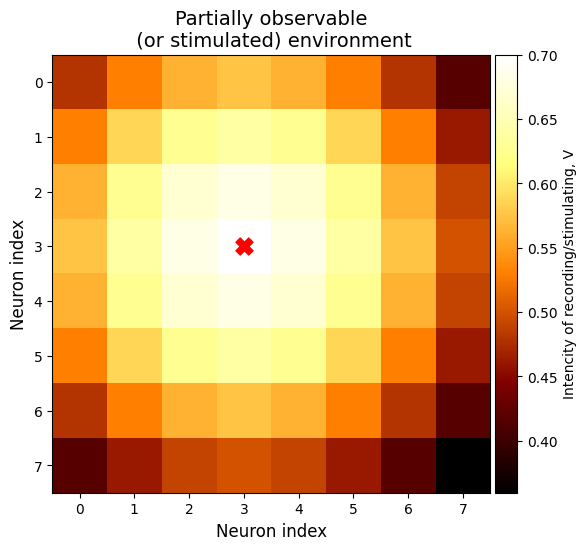

In [11]:
from environment.utils import reshape_vec2grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

neur_grid_temp = env.kuramoto.neur_grid[:, :2]  # make 2d slice
c = env.kuramoto.dbs.conductances[0]
c_reshaped = reshape_vec2grid(c,
                            neur_grid_temp,
                            grid_size)

coordinates_electrode = env.elec_coords[0][:2]
fig, ax = plt.subplots(1,1, figsize=(6, 6))
im = plt.imshow(c_reshaped, cmap='afmhot')
plt.scatter(grid_size[0] - coordinates_electrode[1] - 2,
            coordinates_electrode[0] - 1, 
            c='red', marker='X', s=150)
# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',
             label='Intencity of recording/stimulating, V')

ax.set_title(f'Partially observable\n (or stimulated) environment', fontsize=14)
ax.set_xlabel('Neuron index', fontsize=12)
ax.set_ylabel('Neuron index', fontsize=12)
plt.show()

In [25]:
def calc_LFP(elec_coord, grid_size, 
             distance_matrix, n_grid_coords,
            sol, t_eval, tstart=0, tend=None,):

    elec_idx = elec_coord[0] * grid_size[1] + elec_coord[1]
    print('elec_idx: ', elec_idx)

    dist_vector = distance_matrix[elec_idx]
    conductance = 1 - dist_vector
    conductance = np.where(conductance < 0.0, 0, conductance)

    # Plot Electrode perseption field
    gamma_reshaped = reshape_vec2grid(conductance,
                                      n_grid_coords[:, :2],
                                      grid_size[:2])

    y_dot = grid_size[1] - elec_coord[1] - 1
    plt.scatter(elec_coord[0], y_dot, c='red', marker='X', s=200)
    plt.imshow(gamma_reshaped, interpolation=None, cmap='afmhot')
    plt.title(f'Distance Discount Matrix, {elec_coord}')
    plt.colorbar()
    plt.show()

    # Run environment with new electrode location
    p = params_dict_train.copy()
    p['rec_coords'] = [elec_coord]
    p['conduct_modifier'] = 0.15
    env = SpatialKuramoto(params_dict=p)

    init = env.reset()
    solutions = []
    recordings = []
    for i in tqdm(range(800)):   # 300
        l = env.step([0.])
        m = env.theta_mean
        r = env.theta_records
        theta_state, rew, is_done, _, _ = l
        solutions.append(m)
        recordings.append(r)

    true_lfp_sig = np.concatenate(solutions)
    recorded_sig = np.concatenate(recordings)  
    psd_dt = units2sec(env.params_dict['verbose_dt'])
    trans_time = units2sec(100)
    end_time = true_lfp_sig.shape[0] * psd_dt
    times = np.linspace(trans_time, end_time, true_lfp_sig.shape[0])
    nn = 13_500
    true_lfp_sig_filt, _ = band_pass_envelope(true_lfp_sig, 1/psd_dt, order=2)
    recorded_sig_filt, _ = band_pass_envelope(recorded_sig, 1/psd_dt, order=2)

    fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    ax.plot(t_eval[tstart:tend], true_lfp_sig_filt[tstart:tend], alpha=0.4,
             color='red', label='True LFP')
    ax.plot(t_eval[tstart:tend], recorded_sig_filt[tstart:tend], label=f'LFP from contact {elec_coord}')
    ax.set_title('Difference between contact recordings')

    ax.legend()
    plt.show()

[0, 7, 7]
elec_idx:  7


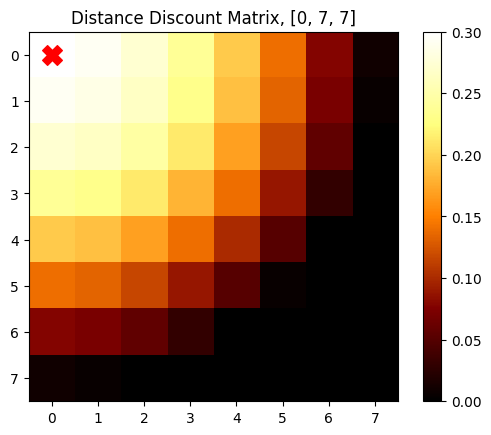

No temporal drift events!
DBS affects 511 neurons, min=0.0 & max=1.0
DBS affects 511 neurons, min=0.0 & max=1.0


100%|██████████| 800/800 [00:42<00:00, 18.66it/s]


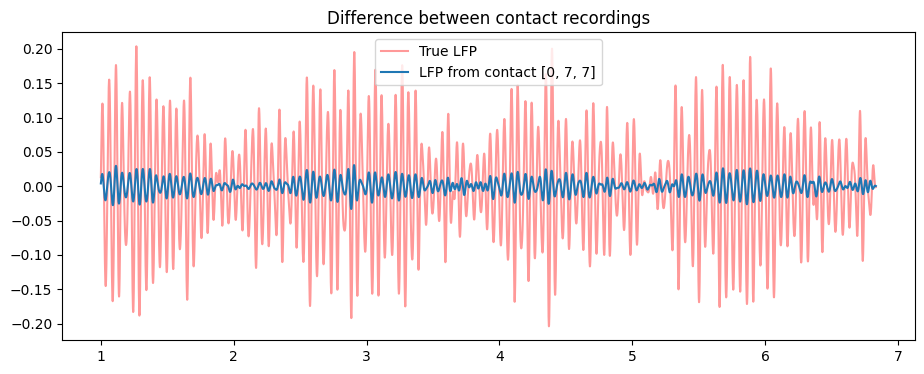

[4, 4, 4]
elec_idx:  36


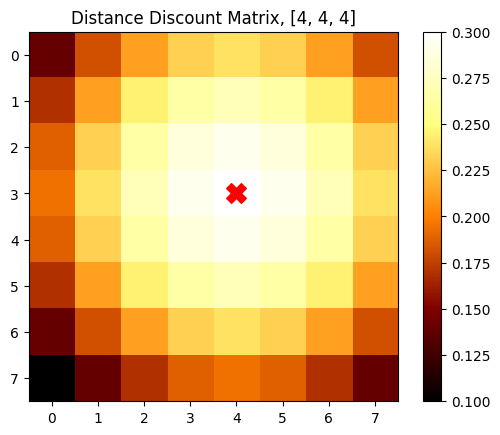

No temporal drift events!
DBS affects 511 neurons, min=0.0 & max=1.0
DBS affects 511 neurons, min=0.0 & max=1.0


100%|██████████| 800/800 [00:46<00:00, 17.20it/s]


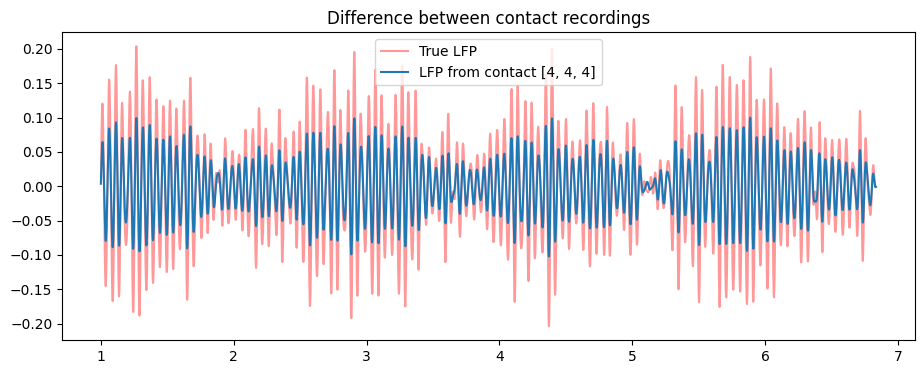

[5, 1, 2]
elec_idx:  41


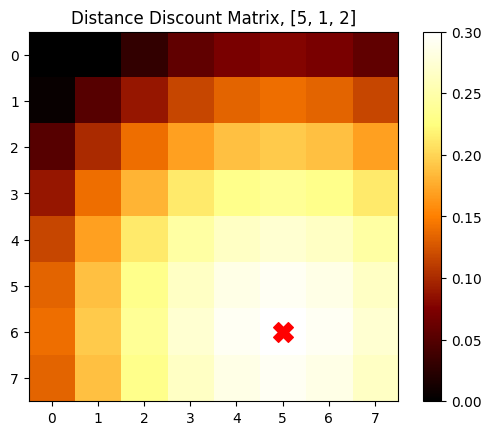

No temporal drift events!
DBS affects 511 neurons, min=0.0 & max=1.0
DBS affects 511 neurons, min=0.0 & max=1.0


100%|██████████| 800/800 [00:43<00:00, 18.37it/s]


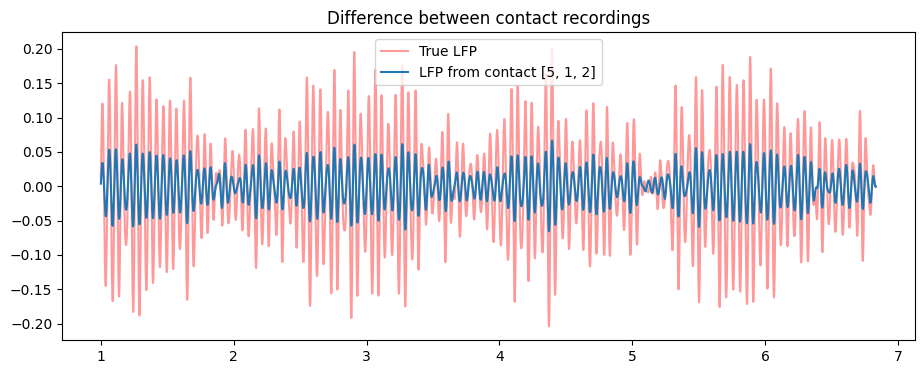

In [ ]:
N = n_neurons

coords = [[0, 7, 7], [4, 4, 4], [5, 1, 2]]

nidx_grid = env.kuramoto.neur_grid
electrode_dist_matrix = create_distance_matrix(nidx_grid*0.1)

sol = []
sol = [s for s in solutions if s.shape[0] == 18]
sol = np.asarray(sol)

for elec_coord in coords:
    print(elec_coord)
    calc_LFP(elec_coord, 
             grid_size=grid_size,
             distance_matrix=electrode_dist_matrix,
             n_grid_coords=nidx_grid,
             sol=sol, 
             t_eval=times,
             tstart=0, 
             tend=100_000)